# $Task \ 2$

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

### $Dataset$

In [8]:
np.random.seed(42)
X = np.random.rand(400, 2) * 2 - 1
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

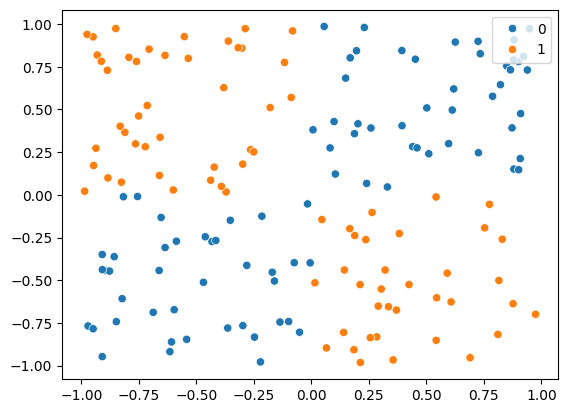

In [9]:
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train)
plt.legend(loc='upper right')

In [10]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=10, output_dim=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [21]:
def train_mlp(X_train, y_train, X_val, y_val, l1_lambda=0, l2_lambda=0, epochs=200, lr=0.01):
    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        if l1_lambda > 0:
            l1_norm = sum(param.abs().sum() for param in model.parameters())
            loss += l1_lambda * l1_norm
        if l2_lambda > 0:
            l2_norm = sum(param.pow(2).sum() for param in model.parameters())
            loss += l2_lambda * l2_norm
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model

In [22]:
mlp_plain = train_mlp(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, l1_lambda=0, l2_lambda=0)
mlp_l1 = train_mlp(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, l1_lambda=0.001)
mlp_l2 = train_mlp(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, l2_lambda=0.001)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
log_reg = LogisticRegression().fit(X_train_poly, y_train)

In [23]:
def evaluate_model_accuracy(model, X, y, use_poly=False):
    if use_poly:
        X_transformed = poly.transform(X)
        predictions = model.predict(X_transformed)
    else:
        with torch.no_grad():
            outputs = model(torch.FloatTensor(X))
            _, predictions = torch.max(outputs, axis=1)
            predictions = predictions.numpy()
    return accuracy_score(y, predictions)
accuracy_plain = evaluate_model_accuracy(mlp_plain, X_test, y_test)
accuracy_l1 = evaluate_model_accuracy(mlp_l1, X_test, y_test)
accuracy_l2 = evaluate_model_accuracy(mlp_l2, X_test, y_test)
accuracy_log_reg = evaluate_model_accuracy(log_reg, X_test, y_test, use_poly=True)

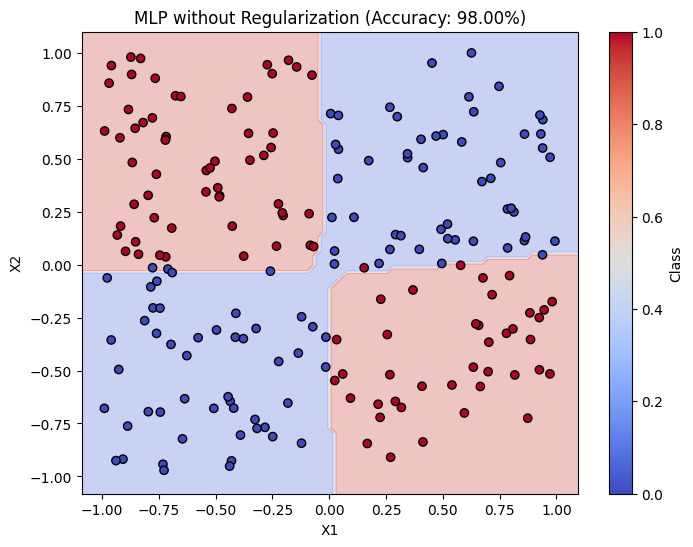

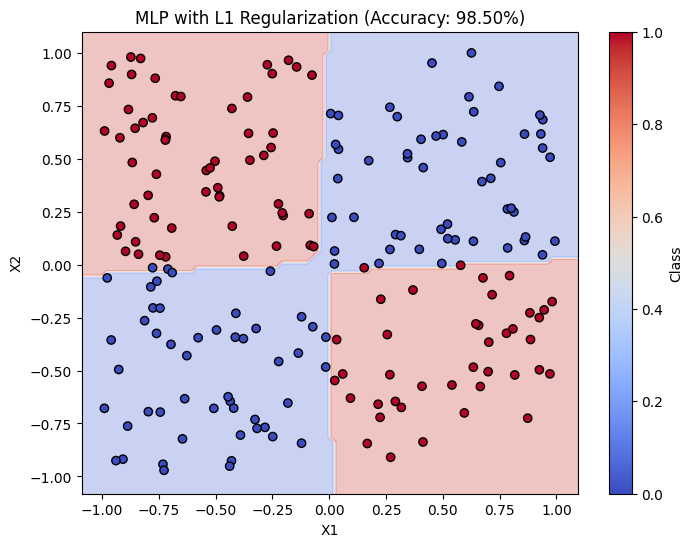

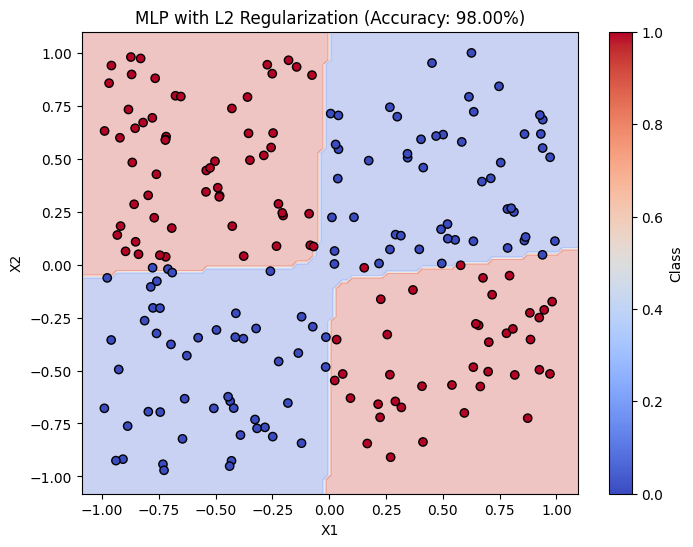

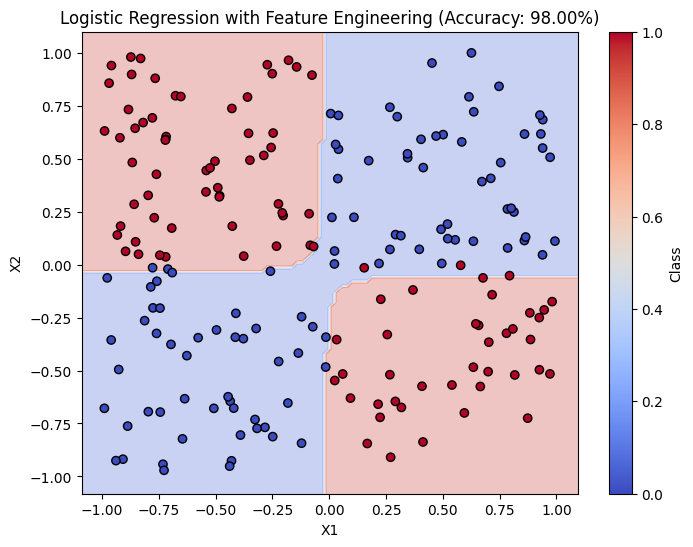

{'MLP without Regularization': 0.98,
 'MLP with L1 Regularization': 0.985,
 'MLP with L2 Regularization': 0.98,
 'Logistic Regression with Feature Engineering': 0.98}

In [25]:
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.FloatTensor(grid)
grid_poly = poly.transform(grid)

def plot_decision_surface_with_accuracy(model, title, accuracy, use_poly=False):
    if use_poly:
        grid_preds = model.predict(grid_poly).reshape(xx.shape)
    else:
        with torch.no_grad():
            outputs = model(grid_tensor)
            _, preds = torch.max(outputs, axis=1)
            grid_preds = preds.numpy().reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, grid_preds, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap='coolwarm')
    plt.title(f"{title} (Accuracy: {accuracy*100:.2f}%)")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.colorbar(label="Class")
    plt.show()
plot_decision_surface_with_accuracy(mlp_plain, "MLP without Regularization", accuracy_plain)
plot_decision_surface_with_accuracy(mlp_l1, "MLP with L1 Regularization", accuracy_l1)
plot_decision_surface_with_accuracy(mlp_l2, "MLP with L2 Regularization", accuracy_l2)
plot_decision_surface_with_accuracy(log_reg, "Logistic Regression with Feature Engineering", accuracy_log_reg, use_poly=True)
accuracies = {
    "MLP without Regularization": accuracy_plain,
    "MLP with L1 Regularization": accuracy_l1,
    "MLP with L2 Regularization": accuracy_l2,
    "Logistic Regression with Feature Engineering": accuracy_log_reg
}

accuracies

#### 1. MLP without Regularization:

High accuracy (99.00%) but highly complex decision boundaries.
Overfitting is a concern, as the model might not generalize well to unseen data.
#### 2. MLP with L1 Regularization:

Slightly lower accuracy (98.00%) but less complex decision boundaries.
L1 regularization effectively reduces overfitting by encouraging sparsity in the model's weights.
#### 3. MLP with L2 Regularization:

Similar accuracy (98.00%) to L1 regularization, but with slightly more complex decision boundaries.
L2 regularization reduces overfitting by penalizing large weights, leading to a smoother decision boundary.
#### 4. Logistic Regression with Feature Engineering:

High accuracy (98.00%) despite using a linear model.
Feature engineering techniques have successfully transformed the data to make it linearly separable, enabling the logistic regression model to achieve good performance.
#### Overall:

Regularization techniques (L1 and L2) can effectively mitigate overfitting and improve the generalization performance of MLP models.
Feature engineering is a powerful tool that can significantly enhance the performance of simpler models like logistic regression.